# Plot EDGAR dataset
The dataset is from timestamp **2016-10-01 00:00:00** to **2016-12-31 23:00:00**  
**requests** represents the maximum number of requests received by the webserver within the given hour, with a resolution of 1s

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [91]:
def parse_datetime(x):
    # return pandas datetime
    return pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S')

series = pd.read_csv(
    './Processed/EDGAR/access.csv', # filename
    header=None, # contains no header
    index_col=0, # set datetime column as index
    names=['datetime', 'requests'], # name the columns
    converters={'datetime': parse_datetime}, # custom datetime parser
    squeeze=True, # convert to Series
    dtype={'requests': np.float64} # https://git.io/vdbyk
)

--- HEAD ---
datetime
2016-10-01 00:00:00     628.0
2016-10-01 01:00:00     644.0
2016-10-01 02:00:00     477.0
2016-10-01 03:00:00     460.0
2016-10-01 04:00:00    5291.0
Name: requests, dtype: float64
--- TAIL ---
datetime
2016-12-31 19:00:00    567.0
2016-12-31 20:00:00    446.0
2016-12-31 21:00:00    556.0
2016-12-31 22:00:00    558.0
2016-12-31 23:00:00    263.0
Name: requests, dtype: float64


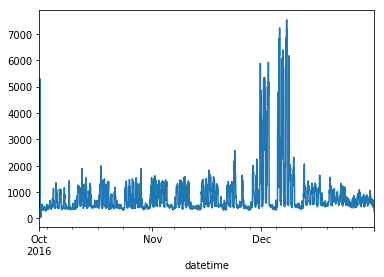

In [92]:
print '--- HEAD ---'
print series.head()
print '--- TAIL ---'
print series.tail()

series.plot();

# Naive forecast
The last observed value will occur in the next time interval

In [93]:
print series[series.last_valid_index()]

263.0


# Autoregressive (AR)
It is a regression of the variable against itself.  
The model is represented as *AR(p)*, where the *AR* process depends on *p* past observations.  

We will be computing *AR(1)*, which is equivalent to *ARIMA(1,0,0)* and *ARMA(1,0)*.

[ 356.49024437  435.10592737  501.21363365  556.80341755  603.54871016
  642.85669497  675.91066862  703.70566191  727.07839343  746.73245749
  763.25950457  777.15705188  788.84346025  798.67052811  806.93408178
  813.88288077  819.72610625  824.6396581   828.77145     832.24586216
  835.16748555  837.62427043  839.69017391  841.42738633  842.88820335
  844.11660027  845.14955578  846.01816515  846.74857633  847.36277703
  847.87925666  848.31356293  848.67876985  848.98587132  849.24411208
  849.46126601  849.64387013  849.79742143  849.92654228  850.03511964
  850.12642203  850.20319796  850.26775862  850.3220475   850.36769886
  850.40608696  850.43836741  850.46551195]


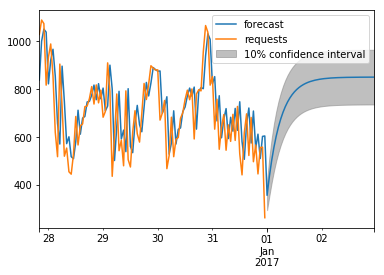

In [94]:
from statsmodels.tsa.arima_model import ARMA

ar = ARMA(series, order=(1,0)) # (p,q) = (1,0)
ar_fit = ar.fit()

print ar_fit.forecast(48)[0]
ar_fit.plot_predict(start=series.tail(100).index[0],
                    end=series.last_valid_index() + pd.Timedelta(hours=48),
                    alpha=0.90);

# Autoregressive Moving Averages (ARMA)
The model is represented as *ARMA(p,q)*,  
where the *AR* process depends on *p* past observations and *MA* process depends on *q* past observations.  

We will be computing *ARMA(1,1)*, which is equivalent to *ARIMA(1,0,1)*.

[ 393.44559318  435.87569864  474.36059561  509.26711488  540.92797886
  569.64497294  595.69182214  619.31680013  640.74509576  660.18095953
  677.80965043  693.79920185  708.30202319  721.45635262  733.38757473
  744.2094157   754.02502728  762.92797004  771.00310517  778.32740332
  784.97067834  790.99625268  796.46156098  801.41869753  805.91491283
  809.99306396  813.6920231   817.04704802  820.09011819  822.85023958
  825.35372116  827.62442565  829.68399696  831.55206655  833.24644051
  834.78326929  836.17720166  837.44152431  838.58828853  839.62842507
  840.57184831  841.42755078  842.20368888  842.90766061  843.5461761
  844.12532156  844.65061729  845.12707031]


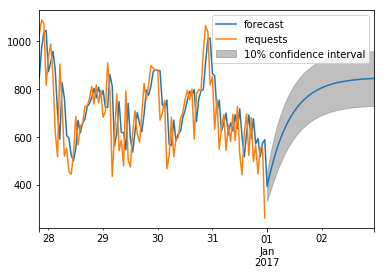

In [95]:
from statsmodels.tsa.arima_model import ARMA

arma = ARMA(series, order=(1,1)) # (p,q) = (1,1)
arma_fit = arma.fit()

print arma_fit.forecast(48)[0]
arma_fit.plot_predict(start=series.tail(100).index[0],
                      end=series.last_valid_index() + pd.Timedelta(hours=48),
                      alpha=0.90);

# Autoregressive Integrated Moving Averages (ARIMA)
The model is represented as *ARIMA(p,d,q)*,  
where the *AR* process depends on *p* past observations, *MA* process depends on *q* past observations,  
and *d* represents the order of integration (to make time-series stationary).  

We will be computing R's equivalent of *auto.ARIMA()*.

### Check for stationarity
- **p-value** should be < 0.05
- **Test Statistic** should be < **Critical Value (5%)**

[Read More](https://datascience.ibm.com/exchange/public/entry/view/815137c868b916821dec777bdc23013c)

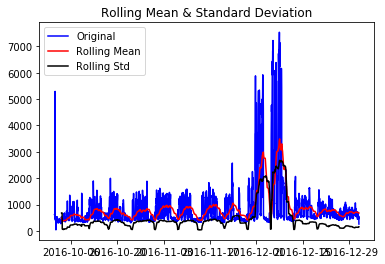

Test Statistic                   -4.450630
p-value                           0.000241
#Lags Used                       27.000000
Number of Observations Used    2180.000000
Critical Value (5%)              -2.862867
Critical Value (1%)              -3.433353
Critical Value (10%)             -2.567476
dtype: float64


In [96]:
# Rolling statistics
rolmean = series.rolling(window=52, center=False).mean()
rolstd = series.rolling(window=52, center=False).std()

orig = plt.plot(series, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# Dickey-Fuller test
dftest = adfuller(series, autolag='AIC')
dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
print dfoutput

[ 401.52386153  416.11897532  452.75376999  480.78926142  512.14837483
  546.67013567  585.76721817  629.14270546  675.79924215  724.03668853
  771.74164319  816.62276918  856.45566871  889.29970463  913.67696481
  928.70067653  934.14623239  930.46229735  918.72429943  900.53696433
  877.89625093  853.02377343  828.18838402  805.5299541   786.89955106
  773.72827731  766.93421502  766.87346557  773.33748662  785.59512816
  802.47425313  822.4748687   843.90350174  865.0172707   884.16579995
  899.91977578  911.17646404  917.23474068  917.83492072  913.16166998
  903.8112964   890.72750386  875.11203728  858.31838511  841.73771957
  826.68649627  814.30461422  805.47182838]


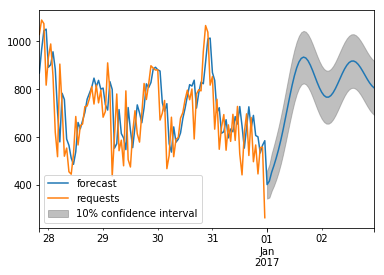

In [97]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
import warnings

# Select p and q
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    arma_params = arma_order_select_ic(series, fit_kw=dict(method='css'))

p = arma_params.bic_min_order[0]
q = arma_params.bic_min_order[1]

arima = ARIMA(series, order=(p,0,q))
arima_fit = arima.fit()

print arima_fit.forecast(48)[0]
arima_fit.plot_predict(start=series.tail(100).index[0],
                       end=series.last_valid_index() + pd.Timedelta(hours=48),
                       alpha=0.90);